# Redistricting Lab

**Objectives**
 - Introduce students to congressional redistricting and gerrymandering
 - Introduce students to a new integer programming formulation
 - Expose students to measures of compactness and the efficiency gap
 - Give students experience creating congressional districts for differet objectives

**Reading:** This lab is based on real congressional redistricting research done by Wes Gurnee and David Shmoys. More information about this research can be found at [fairmandering.org](https://www.fairmandering.org). A more complete description of the algorithm can be found [here](https://www.fairmandering.org/algorithm.html).

**Brief description:** In this lab, we will consider a section of a new paper on congressional redistricting. After summarizing the problem of congressional redistricting, we will give a breif overview of the the paper leading up to the relevant section. Lastly, we will explore possible districts for the state of Georgia subject to various objectives.

<font color='blue'> <b>Solutions are shown blue.</b> </font> <br>
<font color='red'> <b>Instuctor comments are shown in red.</b> </font>

In [1]:
# imports -- don't forget to run this cell!
from redistricting import *
from ortools.linear_solver import pywraplp as OR
%matplotlib inline

# Part I: Redistricting, Gerrymandering, and the Efficiency Gap

Every 10 years in the US, following the census, the process of *reapportionment* determines how the 435 representatives in the House of Representatives will be distributed among the 50 states. Depending on population shifts, a state may lose or gain a representative. Each state is divided in to electoral districts; one for each representative. Hence, after reapportionment, states *redistrict* to redraw the electoral district boundaries. These boundaries are drawn subject to a few federal constraints:

- Districts must have roughly the same population (total state population / number of representatives).
- They must be compact and contiguous.
- You can not divide minorities across multiple districts (cracking) or have a district in which they are the majority (packing).

You may have noticed that there is no restriction on packing or cracking political parties. These two strategies are common in a phenomenon known as *gerrymandering*. Gerrymandering is the process of redrawing these electoral district boundaries to give one political party an advantage over another. In the diagram below, you can see an example of both cracking in packing. 

<img src="images/gerrymandering.png" width=600 height=300 />

*Taken from [The Washington Post](https://www.washingtonpost.com/news/wonk/wp/2015/03/01/this-is-the-best-explanation-of-gerrymandering-you-will-ever-see/)*

Each district shoud have 10 squares. On the right, the two U-shaped districts are packed with blue squares (9/10). The remaining blue squares are then cracked by splitting them among the remaining districts. Even though red is the minority, gerrymandering allow them to have a majority of the districts.

To address this, some states have introduced restrictings aganist this. However, it is hard to police. How can you prove that someone gerrymandered or not? We will look at one fairness metric that has received a lot of attention called the *efficiency gap*. Essentially, the efficiency gap tracks to types of "wasted" votes: lost votes for the losing canidate and excess votes (above 50%) for the winning canidate. 

**Q1:** Consider each square in diagram (3) above a vote. How many wasted votes does blue have? How many are lost votes and how many are excess votes? How does this compare to red?

**A:** <font color='blue'> There are 4 lost votes in each of the 3 red-winning districts and 4 excess votes in each of the 2 blue-winning districts for a total of 20 wasted votes. Conversely, red has 2 lost votes and 3 excess votes for a total of 5 wasted votes. There are many more wasted blue votes. </font>

Now that we know the total wasted votes for each party, we can compute the efficiency gap as follows:

$$\text{Efficiency Gap} = \frac{\text{Total Wasted Blue Votes} - \text{Total Wasted Red Votes}}{\text{Total Votes}}$$

**Q2:** Continuing with our example, what is the efficiency gap?

**A:** <font color='blue'> The efficiency gap is $(20 - 5) / 50 = 0.30$.</font>

You should have found the efficiency gap to be $0.30$. This has the following interpretation: the red party won $30\%$ more seats than they should have. $30\%$ of $5$ is $1.5$. They should have won 2 seats but they managed to win an additional seat. If everything were perfectly fair, the efficiency gap would be 0. However, perfect equality is impossible. The authors of the efficiency gap, Stephanopoulos and McGhee, propose $\pm2\%$ for congressional redistricting.

## Part II: Fairmandering: How to Redistrict Fairly

<font color='red'> Do census tracts have to reside in one district or was this just your approach?</font>

Each state is divided in to census tracts with a population of approximatly 4,000 for the purpose of taking the census. Given a number of representatives $k$, redistricting consists of assigning each of these census tracts to a district subject to compactness and continuity. Subject to these constraints, we could optimize by minimizing the absolute value of the efficiency gap. However, the scale prevents us from formulating a single IP to tackle this whole problem. Below, we load the census tracts for Georgia.

There are 1964 census tracts in Georgia


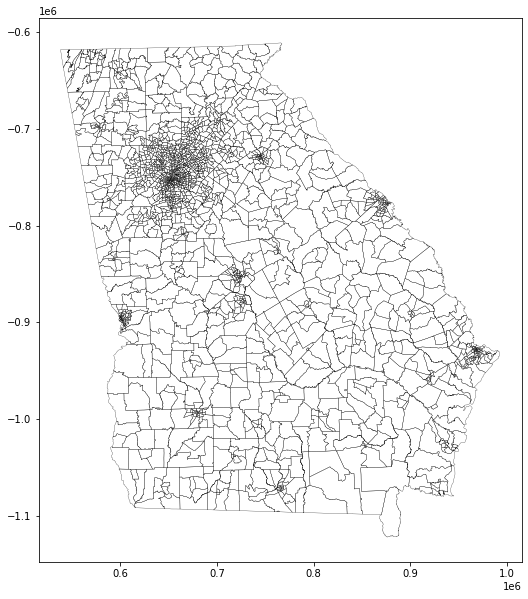

In [2]:
tracts = load_tract_shapes()
tracts.plot(figsize=(10, 10), color='none', edgecolor='black', lw=.25);
print('There are %d census tracts in Georgia' % (len(tracts)))

To keep track of continuity, we can create an adjacency graph where there is a node for each census tract and an edge between two nodes if and only if those census tracts are geographically adjacent.

The adjacency graph has 1964 nodes and 5478 edges.


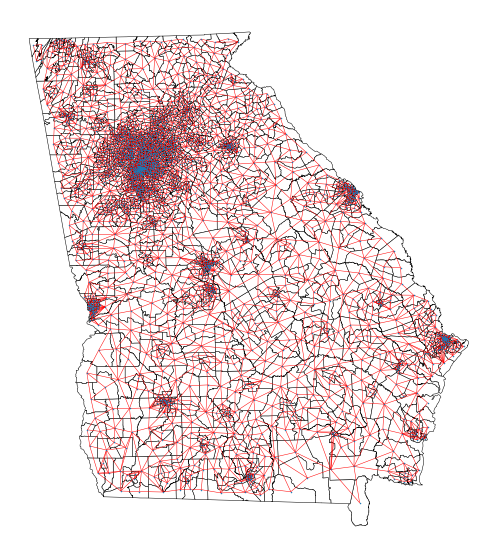

In [3]:
adjacency_graph = load_graph()
draw_adjacency_graph(tracts, adjacency_graph, figsize=(10, 10));
print('The adjacency graph has %d nodes and %d edges.' % (len(adjacency_graph.nodes), len(adjacency_graph.edges)))

Using this adjacency graph, we can generate a list of all feasible districts. We now have a set of census tracts $i \in T$ and a set of feasible districts $j \in D$. Furthermore, we have a matrix $A$ where $a_{ij} = 1$ if and only if census tract $i$ is contained within district $j$. We can compute the efficiency gap $c_j$ for each feasible district $j \in D$. The following formulation then chooses a final set of $k$ districts:

$$\begin{align*}
\min \quad & \left| \enspace \sum_{j \in D} c_jx_j \enspace \right| \\
\text{s.t.} \quad &  \sum_{j \in D} a_{ij}x_j = 1 \quad \forall i \in T & (1)\\
\quad &  \sum_{j \in D}  x_j = k & (2)\\
\quad & x_j \in \{0,1\} \quad \forall j \in D & (3)\\
\end{align*}$$

**Q3:** What are the decision variables? What does their value represent?

**A:** <font color='blue'> The decision variables are $x_j$ for every district $j \in D$. The value of $x_j$ is 1 when district $j$ is chosen to be used.</font>

**Q4:** What does constraint (1) enforce?

**A:** <font color='blue'> Constraint (1) enforces that each census tract $i$ is in exactly one of the selected districts.</font>

**Q5:** What does constraint (2) enforce?

**A:** <font color='blue'> Constraint (2) enforces that exactly $k$ districts are selected.</font>

**Q6:** Is this formulation an integer linear program? Why or why not?

**A:** <font color='blue'>No, the objective function is not linear because it has an absolute value.</font>

It turns out there is a special trick for encoding an absolute value in a linear program. Consider the simpler example of maximizing $x$. We can introduce a new variable $w$ and enforce the constraints $x \leq w$ and $x \geq -w$. Now, we can just minimize $w$ as our objective function. Do you see why this works? After introducing this trick into our formulation, we get the following integer linear program (ILP):

$$\begin{align*}
\min \quad & w \\
\text{s.t.} \quad &  \sum_{j \in D} a_{ij}x_j = 1 \quad \forall i \in T & (1)\\
\quad &  \sum_{j \in D}  x_j = k & (2)\\
\quad & \sum_{j \in D} c_jx_j \leq w & (3) \\
\quad & \sum_{j \in D} c_jx_j \geq -w & (4) \\
\quad & x_j \in \{0,1\} \quad \forall j \in D & (5)\\
\end{align*}$$

**Q7:** How many variables does this ILP have? Do you think this ILP is reasonable as is for a state with nearly 2000 census tracts? (Hint: How many feaisble districts do you think that would generate?)

**A:** <font color='blue'> The number of feasible districts plus one. This is not reasonable as is because there would be way too many variables!</font>

The paper by Wes Gurnee and David Shmoys addressee this very issue! They formualated a structured way of generating a large number of compatible feasible districts (though small relative to the total number possible). We won't go in to detail about this process but here is a breif overview.

Esssentially, the state is divided into some number of smaller regions (partitioned) some number of times (385 in the case of this Georgia example). For each of these partitions, this process is repeated until the size of the regions is appropriate for the size of a district. Here is a small section of sample tree: 

<img src="images/sample_tree.png" width=650 height=300 />

*Taken from [fairmandering.org](https://www.fairmandering.org/algorithm.html)*

The root of this tree is the entire state. In the first layer of the tree, you have the first partitions (which we call root partitions). In the last layer of the tree (also called the leaf nodes), the partions represent the feasible districts. Just one more piece of vocabulary! If you can follow a path directly down from one node $a$ to another $b$, we say that $a$ is a ancestor of $b$. For example, the middle root partition is an ancestor of every shown leaf. The right and left root partitions are **not** ancestors of any shown leaf.

**Q8:** Can two districts who have different root partition ancestors be used in the same plan together? Why or why not?

**A:** <font color='blue'> No, the "puzzle pieces" would not fit!</font>

In **Q8**, you should have argued that they would not be compatible. Hence, we solve this optimization problem for each of the root partitions. Each root partition is the ancestor of some subset of the leafs which represent feasible districts. For each root partition, we can use these feasible districts as the input to the ILP we described! Let's try it out!

## Part III: Redistricting Georgia

First, let's look at some of the data we have. The dataframes below give us some statistics and past election results for each census tract.

In [4]:
tract_stats = load_state_df()
display(tract_stats.head())
tract_results = load_election_df()
display(tract_results.head())

,GEOID,x,y,area,population,p_public_transportation_commute,p_walk_commute,mean_commute_time,p_bachelors_degree_or_higher,unemployment_rate,...,p_age_students,median_age,p_mobile_homes,p_without_person_vehicle,p_veterans,2000,2004,2008,2012,2016
0,13001950100,858073.274928,-954008.270831,332.577797,3011,0.0,1.9,20.6,13.7,7.1,...,10.4,42.4,36.4,6.0,9.0,0.653075,0.708609,0.73366,0.748534,0.793014
1,13001950200,854327.007094,-961700.604998,157.961971,4301,1.5,2.0,21.6,11.0,1.6,...,15.5,38.7,39.8,11.8,8.9,0.653075,0.708609,0.73366,0.748534,0.793014
2,13001950300,848608.690803,-967396.534007,72.030374,5609,0.0,0.8,22.9,5.2,8.7,...,7.1,36.8,26.3,13.5,7.5,0.653075,0.708609,0.73366,0.748534,0.793014
3,13001950400,866679.762897,-977255.292313,389.608817,1669,0.0,0.0,30.2,9.8,6.9,...,17.0,44.4,34.8,5.9,5.0,0.653075,0.708609,0.73366,0.748534,0.793014
4,13001950500,848558.128112,-974848.057797,375.617826,3864,0.0,1.2,22.9,11.7,5.3,...,18.3,38.0,48.7,3.3,6.2,0.653075,0.708609,0.73366,0.748534,0.793014


,D_pres_2016,D_senate_2016,R_pres_2016,R_senate_2016,D_gov_2018,D_AG_2018,R_gov_2018,R_AG_2018,D_pres_2008,R_pres_2008,D_pres_2012,R_pres_2012
0,118.976380,113.833984,1228.740713,1138.656102,98.336016,120.571006,1220.973312,1162.348625,198.956156,1148.760937,178.910936,1168.806157
1,735.846511,585.415804,826.726385,810.174598,746.404700,705.957397,776.081801,751.312270,828.576826,733.996070,805.335956,757.236940
2,142.722300,112.224541,618.825657,585.135149,111.532707,115.983323,456.481014,428.724465,187.916084,573.631873,176.589229,584.958729
3,210.333782,171.992717,970.651386,922.888445,198.123861,205.243347,1143.934378,1096.275617,280.418913,900.566255,262.853574,918.131594
4,226.039033,203.460763,1848.445280,1712.578804,203.602699,236.244910,1830.529356,1739.338889,349.148543,1725.335770,318.293778,1756.190535


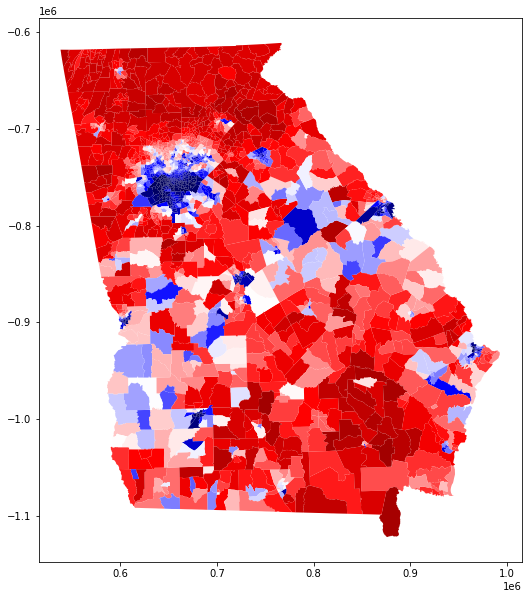

In [5]:
# Plot 2016 presidential election results
tracts['2016_pres'] = tract_results.apply(lambda x: x.R_pres_2016 / (x.R_pres_2016 + x.D_pres_2016), axis=1)
tracts.plot(column='2016_pres', cmap='seismic', vmin=0, vmax=1, figsize=(15, 10));

We skipped a lot of complexity involved in generating a sample tree. For the sake of this lab, this data has been given to us.

In [6]:
leaf_nodes = pickle.load(open('data/leaf_nodes.p', 'rb'))
internal_nodes = pickle.load(open('data/internal_nodes.p', 'rb'))
print('There are %d root partitions and %d feasible districts.' % (len(internal_nodes[0]['children_ids']), 
                                                                   len(leaf_nodes)))

There are 385 root partitions and 215785 feasible districts.


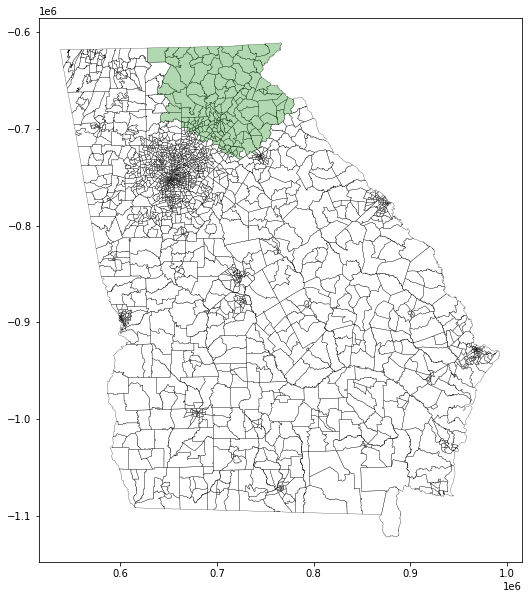

In [7]:
# change i (0..215784) to highlight different feasible districts corresponding to the leaf nodes
i = 0
ax = tracts.plot(figsize=(10, 10), color='none', edgecolor='black', lw=.25) 
tracts.iloc[leaf_nodes[i]['area']].plot(ax=ax, color='green', alpha=.3);

For each feasible district, we can aggregate over the census tract statistics contained within it to get statistics for each feasible district. In addition to the aggregate statistics, we have also computed some measures of compactness: `roeck`, `edge_ratio`, and `cut_edges` (which we will discuss later) and the efficiency gap for each district.

In [8]:
district_df = pd.read_csv(os.path.join('data', 'ga_district_df.csv'))
district_df['efficiency_gap'] = efficiency_gap_coefficients(district_df, .53)
display(district_df.head())

,GEOID,x,y,area,population,p_public_transportation_commute,p_walk_commute,mean_commute_time,p_bachelors_degree_or_higher,unemployment_rate,...,D_pres_2012,R_pres_2012,mean,std_dev,DoF,dispersion,roeck,edge_ratio,cut_edges,efficiency_gap
0,1.314602e+10,703256.530393,-683238.278815,11620.575332,741282.0,0.263438,1.060602,28.708458,24.660949,4.415160,...,54878.667195,238264.578182,0.799446,0.015679,5,33.760417,0.689454,2.559441,79,0.439996
1,1.315523e+10,593515.520895,-670198.460670,12074.251776,729379.0,0.330174,1.331401,26.312435,17.059684,5.861012,...,61557.904496,196644.896626,0.778598,0.026533,5,41.635791,0.541537,2.581395,39,0.439932
2,1.315163e+10,598063.232258,-665663.233476,11614.689714,728249.0,0.349841,1.366476,26.185927,17.888402,5.887867,...,60598.859065,196301.469223,0.778885,0.025600,5,39.888216,0.627797,2.585938,36,0.439943
3,1.314296e+10,707134.463222,-688229.849150,10146.377476,734472.0,0.309298,1.039873,29.025757,25.267252,4.267012,...,56088.784870,231149.162240,0.788368,0.016061,5,31.086731,0.908944,2.610294,71,0.439995
4,1.310710e+10,621078.264937,-738691.322260,2955.850099,742702.0,0.962230,0.766883,34.362520,30.987041,5.725069,...,117931.610853,175607.309792,0.559761,0.036215,5,16.856137,0.712542,2.509804,71,0.360092


**Q9:** Complete the model below by implementing the $k$ total districts constraint.

In [9]:
def redistrict(k, tract_district_matrix, cost, integer=False, opt_type='abs_val', solver='CBC'):
    """A model for solving a congressional redistricting problem.
    
    Args:
        k (int): number of districts in a plan
        tract_district_matrix (np.ndarray): binary matrix a_ij = 1 if tract i is in district j
        costs (np.ndarray): cost coefficients of districts
        opt_type (str): {"minimize", "maximize", "abs_val"}
        solver (str) : {"CBC", "gurobi"}
    """
    n_tracts, n_columns = tract_district_matrix.shape
    TRACTS = range(n_tracts)
    DISTRICTS = range(n_columns)
    
    # define the model
    if solver=='CBC':
        m = OR.Solver('redistrict', OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)        
    elif solver=='gurobi':
        m = OR.Solver('redistrict', OR.Solver.GUROBI_MIXED_INTEGER_PROGRAMMING)
    else:
        raise ValueError('Invalid solver')

    # decision variables
    x = {} # x_i is 1 if district i is used, 0 otherwise
    for d in DISTRICTS:
        if integer:
            x[d] = m.IntVar(0, 1, name="x(%s)" % d)
        else:
            x[d] = m.NumVar(0, 1, name="x(%s)" % d)

    # objective function
    if opt_type == 'min':
        m.Minimize(sum(cost[d] * x[d] for d in DISTRICTS))
    elif opt_type == 'max':
        m.Maximize(sum(cost[d] * x[d] for d in DISTRICTS))
    elif opt_type == 'abs_val':
        w = m.NumVar(-k, k, name="w")
        m.Add(sum(cost[d] * x[d] for d in DISTRICTS) <= w, name='absval_pos')
        m.Add(sum(cost[d] * x[d] for d in DISTRICTS) >= -w, name='absval_neg')
        m.Minimize(w)
    else:
        raise ValueError('Invalid optimization type')

    # subject to: each census tract appears in exactly one district
    for t in TRACTS:    
        m.Add(sum(x[d] * tract_district_matrix[t,d] for d in DISTRICTS) == 1)

    # subject to: k total districts
    # TODO: Implement this constraint
    
    ### BEGIN SOLUTION
    m.Add(sum(x[d] for d in DISTRICTS) == k)
    ### END SOLUTION

    return m,x

In [10]:
# You do not need to pay attention to this cell but make sure you run it!
def solve(m, solver='CBC'):
    """Solve the model and specify some solver parameters."""
    if solver=='CBC':
        m.SetTimeLimit(int(len(leaf_nodes) / 10))
        params = OR.MPSolverParameters()
        params.SetDoubleParam(params.RELATIVE_MIP_GAP, 1e-4)
        status = m.Solve(params)
    elif solver=='gurobi':
        params_set = m.SetSolverSpecificParametersAsString(
                     '''TimeLimit %d
                        MIPGapAbs %d''' % ((len(leaf_nodes) / 10), 1e-4))
        if params_set:
            print('Gurobi solver parameters set successfully.')
        status = m.Solve()
    if status == OR.Solver.OPTIMAL:
        print('Optimal solution found.')
        print('Objective value =', m.Objective().Value())
    else:
        print('Optimal solution was not found - %s' % (status))

Before running our model, we first need to format our data to fit the models input. We want to split Georgia into 14 districts. The matrix $A$ is equivalent to `tract_district_matrix`. Lastly, we get a map from root partitions to the relevant leaf nodes; each representing a problem instance.

In [11]:
n_districts = 14
tract_district_matrix = make_tdm(leaf_nodes, len(tracts))
partition_map = list(make_root_partition_to_leaf_map(leaf_nodes, internal_nodes).items())

Unfortunately, this problem is still large enough that the open-source solver we use in this class (CBC) would take a little over an hour to solve all 385 root partitions. For that reason, we will solve a small subset of these root partitions. The function below solves some subset of the root partitions for given cost coefficents and an optimization type.

In [12]:
def solve_root_partitions(cost, opt_type, index_subset):
    '''Solve a subset of the root partitions and return a list of each solution.'''
    solutions = []
    for i in index_subset:
        partition_ix, leaf_slice = partition_map[i]
        m,x = redistrict(k=n_districts,
                         tract_district_matrix=tract_district_matrix[:, leaf_slice],
                         cost=np.array(cost)[leaf_slice],
                         integer=True,
                         opt_type=opt_type,
                         solver='CBC')
        solve(m, solver='CBC')
        opt_cols = [j for j, v in x.items() if v.solution_value() > .5]
        solutions.append({'n_leaves': len(leaf_slice),
                          'solution_ixs': leaf_slice[opt_cols],
                          'optimal_objective': np.array(cost)[leaf_slice][opt_cols]})
    return solutions

We want to minimize the absolute value of the efficency gap!

In [13]:
solutions = solve_root_partitions(district_df['efficiency_gap'], 'abs_val', [4,5,6])

Optimal solution found.
Objective value = 3.059958658013784e-06
Optimal solution found.
Objective value = 0.19027442261284833
Optimal solution found.
Objective value = 0.5045015117462182


Now that we have some solutions, we need to pick one of them. The simplest thing to do is pick the one with the smallest efficiency gap.

In [14]:
for sol in solutions:
    e_gap = round(district_df.loc[sol['solution_ixs']]['efficiency_gap'].mean(),5)
    print(e_gap)

-0.0
0.01359
0.03604


**Q10:** Just by looking at the efficiency gap for each of these solutions, which of these is the most fair? 

**A:** <font color='blue'> The first solution is the most fair because the efficiency gap is almost 0.</font>

**Q11:** In the third solution, the efficiency gap is nearly $0.04$. For which party is this an advantage?

**A:** <font color='blue'> This favors the The Republican Party. </font>

Let's look at each solution graphically since there are only 3!

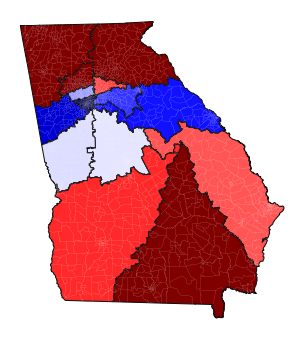

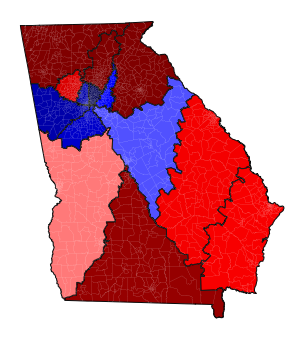

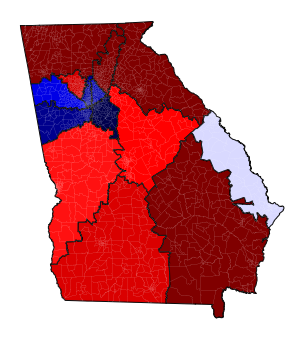

In [15]:
for sol in solutions:
    politics_map(tracts, district_df, leaf_nodes, sol, figsize=(6,6));

**Q12:** Do these solutions reflect what you would expect from the efficiency gaps?

**A:** <font color='blue'> Yes, both the second and third solution have higher positive efficiency gaps which means more democratic votes were wasted. We can see more evidence of packing in these solutions.</font>

## Part IV: Redistricting Georgia (Different Objectives)

In **Part III** we minimized the absolute value of the efficiency gap to make things fair. Alternatively, we could use this same tool to gerrymander. For example, if we wanted to gerrymander to favor The Republican Party, we would want to maximize the efficiency gap. Let's do this for the same root partitions we optimized to be fair.

In [16]:
solutions = solve_root_partitions(district_df['efficiency_gap'], 'max', [4,5,6])

Optimal solution found.
Objective value = 2.4642013581218194
Optimal solution found.
Objective value = 2.562909394276722
Optimal solution found.
Objective value = 2.7322768830892974


0.17601
0.18306
0.19516


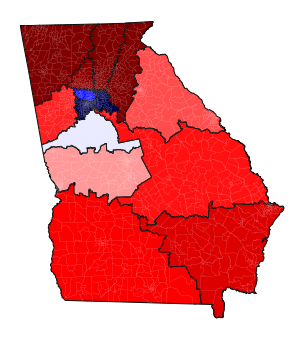

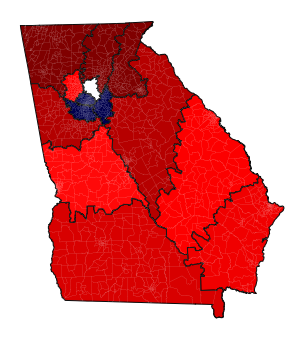

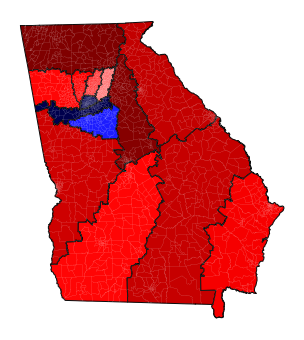

In [17]:
for sol in solutions:
    politics_map(tracts, district_df, leaf_nodes, sol, figsize=(6,6));
    e_gap = round(district_df.loc[sol['solution_ixs']]['efficiency_gap'].mean(),5)
    print(e_gap)

**Q13:** How effective was the gerrymandering? How did the most fair solution (6 D, 8 R seats) compare to solution with the highest efficiency gap here? Based on the interpretation of the efficiency gap, does this make sense?

**A:** <font color='blue'> There are 11 R seats and only 3 D seats. The efficiency gap was ~$20\%$ so we would expect the The Republican Party to get $0.20(14) = ~2.8$ more seats and they got 3 more!</font>

**Q14:** How was the Democratic vote supressed so heavily?

**A:** <font color='blue'> All of the democratic votes were packed into 3 urban districts.</font>

**Q15:** Choose the correct cost coefficents and optimization type to gerrymander for The Democratic Party 

**Note**: We look at a different 3 root partitions here because the previous 3 are hard to gerrymander in the The Democratic Party's favor.

In [18]:
# TODO: Uncomment, and gerrymander for The Democratic Party
# solutions = solve_root_partitions(, , [4,110,216])

### BEGIN SOLUTION
solutions = solve_root_partitions(district_df['efficiency_gap'], 'min', [4,110,216])
### END SOLUTION

Optimal solution found.
Objective value = -0.2688574948548905
Optimal solution found.
Objective value = -0.3946947261526662
Optimal solution found.
Objective value = -0.23983968029233105


-0.0192
-0.02819
-0.01713


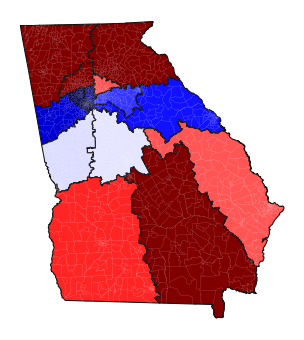

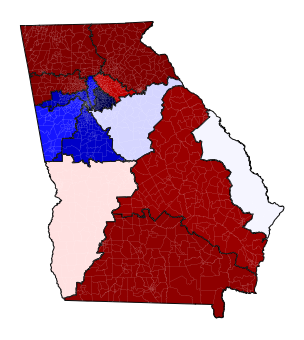

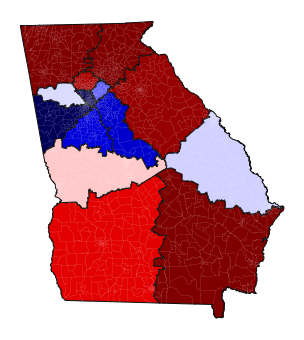

In [19]:
for sol in solutions:
    politics_map(tracts, district_df, leaf_nodes, sol, figsize=(6,6));
    e_gap = round(district_df.loc[sol['solution_ixs']]['efficiency_gap'].mean(),5)
    print(e_gap)

**Q16:** How effective was the gerrymandering? How did the most fair solution (6 D, 8 R seats) compare to solution with the highest efficiency gap here? Based on the interpretation of the efficiency gap, does this make sense?

**A:** <font color='blue'> There are 7 R seats and 7 D seats. The efficiency gap was ~$0.03\%$ so we would expect the The Republican Party to get $0.03(14) = ~0.42$ more seats and they got 1 more!</font>

**Q17:** How was the Republican vote supressed so heavily?

**A:** <font color='blue'> The republican votes were heavily packed allowing for the democrats to spread their majority across multiple districts coming into the urban center. </font>

Up to this point, we have focused on optimizing around partisanship. However, we could also optimize around other measures like compactness. In  order to do this, we need to decide how to measure compactness. One possible measure is called the Roeck test. First, the smallest circle enclosing the district is found. Then, the area of the district is divded by the area of that circle. More compact districts will have a measure closer to 1. Let's look at some examples.

Roeck measure: 0.118451
Roeck measure: 0.496433
Roeck measure: 0.999246


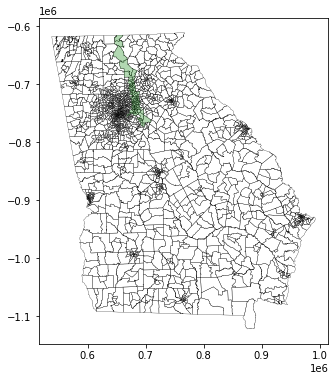

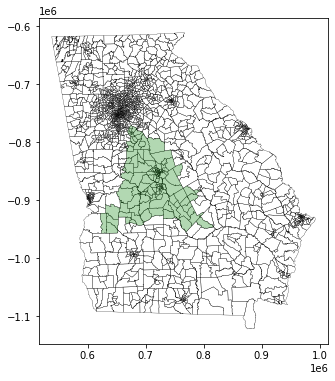

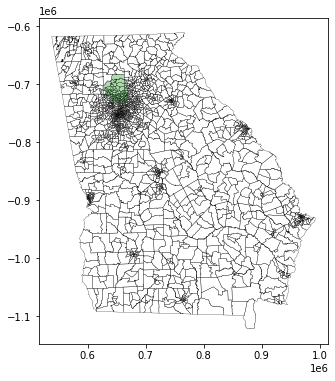

In [20]:
for i in [40339, 215783, 107817]:
    ax = tracts.plot(figsize=(6, 6), color='none', edgecolor='black', lw=.25) 
    tracts.iloc[leaf_nodes[i]['area']].plot(ax=ax, color='green', alpha=.3);
    print('Roeck measure: %f' % (district_df.loc[i]['roeck']))

**Q18:** Choose the correct cost coefficents and optimization type to maximize the compactness of the districts using the Roeck test. (Hint: the column `roeck` gives the Roeck measure for each district)

In [21]:
# TODO: Uncomment, and maximize the compactness of the districts
# solutions = solve_root_partitions(, , [4,5,6])

### BEGIN SOLUTION
solutions = solve_root_partitions(district_df['roeck'], 'max', [4,5,6])
### END SOLUTION

Optimal solution found.
Objective value = 9.455854205078934
Optimal solution found.
Objective value = 9.333839603571237
Optimal solution found.
Objective value = 8.932542348007075


0.67542
0.6667
0.63804


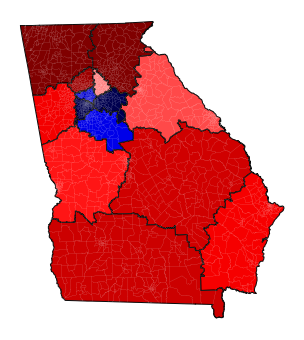

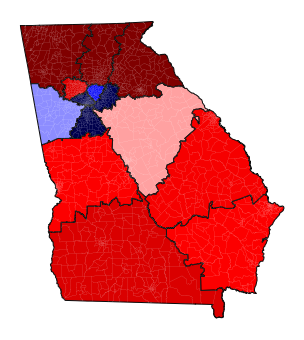

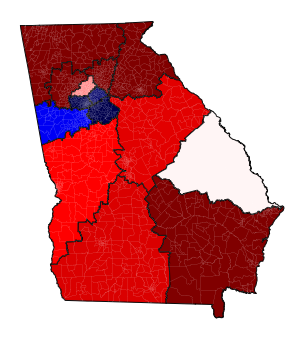

In [22]:
for sol in solutions:
    politics_map(tracts, district_df, leaf_nodes, sol, figsize=(6,6));
    roeck = round(district_df.loc[sol['solution_ixs']]['roeck'].mean(),5)
    print(roeck)

**Q19:** Which party does maximizing compactness benefit? Why?

**A:** <font color='blue'> This benefits The Republican Party because compact districts pack the Democratic majority which is in dense in small urban areas.</font>

Another measure of compactness one could use is the number of cut edges. Think back to the adjacency graph. The number of cut edges is the number of edges one would have to remove to make the district a separate component from the rest of the graph. The more cut edges, the less compact the distict is.

**Q20:** Choose the correct cost coefficents and optimization type to minimize the compactness of the districts using cut edges. (Hint: the column `cut_edges` gives the number of cut edges for each district)

In [23]:
# TODO: Uncomment, and maximize the compactness of the districts
# solutions = solve_root_partitions(, , [4,5,6])

### BEGIN SOLUTION
solutions = solve_root_partitions(district_df['cut_edges'], 'max', [4,5,6])
### END SOLUTION

Optimal solution found.
Objective value = 1370.0
Optimal solution found.
Objective value = 1318.0
Optimal solution found.
Objective value = 1384.0


97.85714
94.14286
98.85714


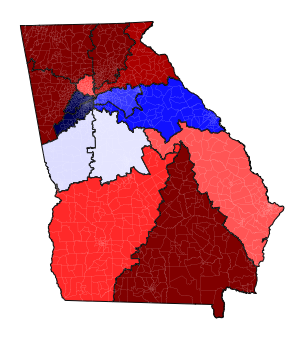

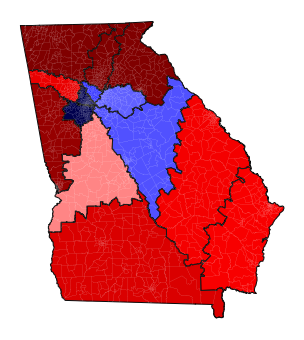

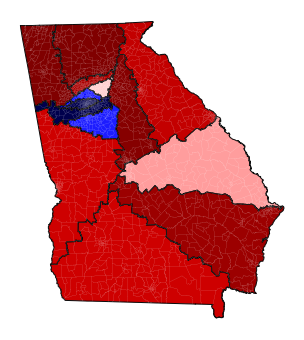

In [24]:
for sol in solutions:
    politics_map(tracts, district_df, leaf_nodes, sol, figsize=(6,6));
    cut_edges = round(district_df.loc[sol['solution_ixs']]['cut_edges'].mean(),5)
    print(cut_edges)